In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
import os
from scipy.stats import binned_statistic, binned_statistic_dd


ERROR 1: PROJ: proj_create_from_database: Open of /nesi/project/niwa00018/queenle/ml_env_v2/share/proj failed


In [ ]:
counts_dir = '/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/compute_metrics/results/histogram_counts'
plot_dir = '/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/plots/histograms'
final_figure_dir = '/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/final_figures'

capitalized = {'GAN':'GAN','unet':'U-Net','rx1d':'Rx1d','annual_mean':'Annual Mean',\
               'DJF_mean':'DJF Mean','JJA_mean':'JJA Mean','total_max':'Total Max',\
               'perfect':'Perfect','imperfect':'Imperfect'}

colors = {'GAN':'blue','unet':'orange'}


In [ ]:
def get_lhd_db(h1, h2, eps=1e-12):
    h1 = np.asarray(h1)
    h2 = np.asarray(h2)
    assert h1.shape == h2.shape, "Histograms must have the same shape"
    
    mask = (h1 >= 10) & (h2 >= 10)
    h1 = h1[mask]
    h2 = h2[mask]

    log_diff_dB = 10 * (np.log10(h1) - np.log10(h2))
    lhd_db = np.sqrt(np.mean(log_diff_dB ** 2))
    
    return lhd_db

def get_lhd(h1, h2):
    # Convert to arrays in case they're lists
    h1 = np.asarray(h1)
    h2 = np.asarray(h2)
    
    assert h1.shape == h2.shape, "Histograms must have the same shape"
    
    mask = (h1 >= 10) & (h2 >= 10)
    h1 = h1[mask]
    h2 = h2[mask]
    
    return np.sum(np.abs(np.log1p(h1) - np.log1p(h2)))

def write_to_dict(result_dict,period,epoch,gcm,ml_type,framework,n,lhd_db):
    
    result_dict['period'].append(period)
    result_dict['epoch'].append(epoch)
    result_dict['GCM'].append(gcm)
    result_dict['ml_type'].append(ml_type)
    result_dict['framework'].append(framework)
    result_dict['sample_n'].append(n)
    result_dict['lhd_db'].append(lhd_db)
    

In [4]:
'''
Plot histograms 
'''

labels = [['(a)','(b)'],
          ['(c)','(d)'],
          ['(e)','(f)'],
          ['(g)','(h)'],
          ['(i)','(j)'],
          ['(k)','(l)']]

epochs = ['220','225','230']
epoch_string = '-'.join(epochs)

for period in [('1985','2004')]:#,('2080','2099')]:
    
    start,end = period
    
    for gcm in ['NorESM2-MM']:#'EC-Earth3',

        fig,axs = plt.subplots(5,2,figsize=(8,12),sharex=True,sharey=True,layout='constrained')

        for j,framework in enumerate(['perfect','imperfect']):

            gan_dfs = []
            unet_dfs = []
            for epoch in epochs:
                gan_df = pd.read_csv(f'{counts_dir}/{gcm}_GAN_{framework}_epoch_{epoch}_{start}-{end}_histogram_counts.csv').drop('Unnamed: 0',axis=1)
                unet_df = pd.read_csv(f'{counts_dir}/{gcm}_unet_{framework}_epoch_{epoch}_{start}-{end}_histogram_counts.csv').drop('Unnamed: 0',axis=1)

                gan_dfs.append(gan_df)
                unet_dfs.append(unet_df)
                
            gan_mean = sum(gan_dfs)/3
            unet_mean = sum(unet_dfs)/3

            for i,n in enumerate([10,20,60,100,140]):

                bins = gan_mean['bin_left'].values.tolist() + [gan_mean['bin_right'].values[-1]]

                gan_counts = gan_mean[str(n)]
                unet_counts = unet_mean[str(n)]
                ccam_counts = gan_mean['CCAM']

                axs[i][j].stairs(gan_counts,bins,color=colors['GAN'],label=capitalized['GAN'])
                axs[i][j].stairs(unet_counts,bins,color=colors['unet'],label=capitalized['unet'])
                axs[i][j].stairs(ccam_counts,bins,color='green',label=f'CCAM')
                    
                axs[i][j].set_yscale('log')

                axs[i][j].text(0.5,0.75,f'{labels[i][j]} {n} years', transform=axs[i][j].transAxes,ha='center', va='bottom', fontsize=20)

                axs[i][j].set_yscale('log')
                axs[i][j].tick_params(axis='y', labelsize=16)
                axs[i][j].tick_params(axis='x', labelsize=16)

                if i == 5:
                    axs[i][j].set_xlabel('pr (mm/day)',fontsize=22)

        axs[0][0].set_title('Perfect',fontsize=22)
        axs[0][1].set_title('Imperfect',fontsize=22)

        axs[2][0].set_ylabel('Count',fontsize=22)

        handles, lbls = axs[0][0].get_legend_handles_labels()
        legend = fig.legend(handles, lbls, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.08),fontsize=22)

        #plt.savefig(f'{plot_dir}/{gcm}_{epoch_string}_epoch_average_{start}-{end}.png',dpi=300, bbox_inches='tight', bbox_extra_artists=(legend,))
        plt.savefig(f'{final_figure_dir}/Figure4.png',dpi=300, bbox_inches='tight', bbox_extra_artists=(legend,))
        plt.close()



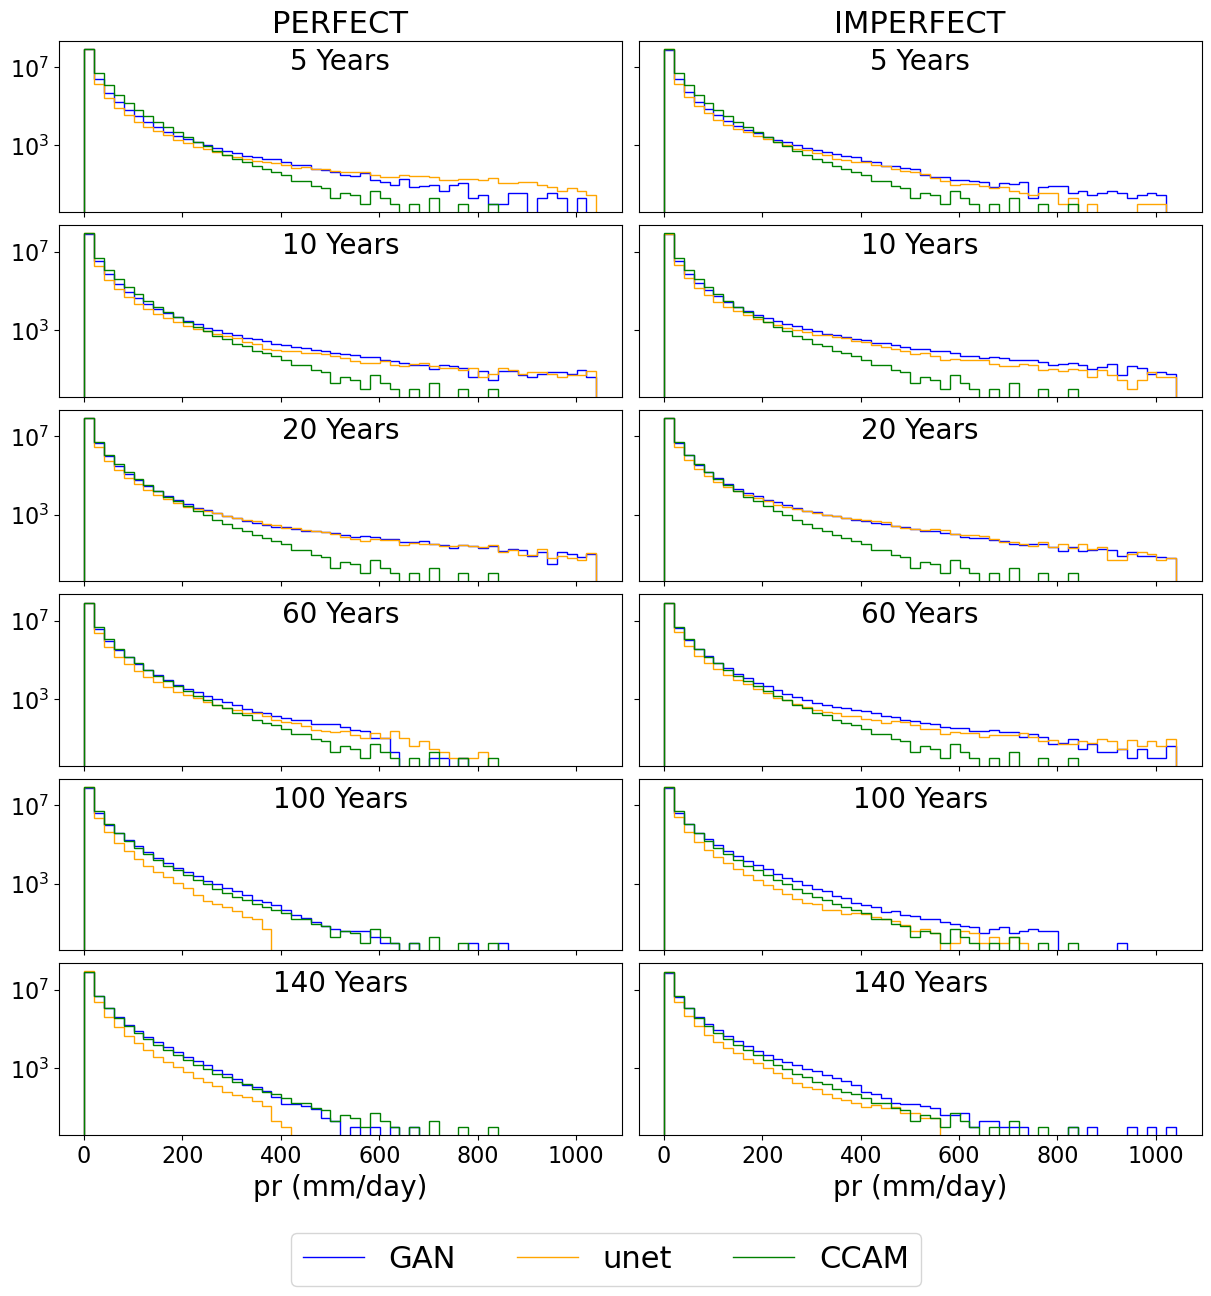

In [ ]:
'''
Plot histograms 
'''

for period in [('1985','2004')]:#,('2080','2099')]:
    
    start,end = period
    
    for gcm in ['EC-Earth3','NorESM2-MM']:

        for epoch in ['220','225','230']:

            if os.path.exists(f'/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/histograms/{gcm}_epoch_{epoch}_{start}-{end}.png'):
                print('file exists, skipping')
                continue
                
            

            fig,axs = plt.subplots(6,2,figsize=(12,12),sharex=True,sharey=True,layout='constrained')

            for j,framework in enumerate(['perfect','imperfect']):

                gan_df = pd.read_csv(f'{counts_dir}/{gcm}_GAN_{framework}_epoch_{epoch}_{start}-{end}_histogram_counts.csv').drop('Unnamed: 0',axis=1)
                unet_df = pd.read_csv(f'{counts_dir}/{gcm}_unet_{framework}_epoch_{epoch}_{start}-{end}_histogram_counts.csv').drop('Unnamed: 0',axis=1)

                for i,n in enumerate([5,10,20,60,100,140]):

                    bins = gan_df['bin_left'].values.tolist() + [gan_df['bin_right'].values[-1]]

                    gan_counts = gan_df[str(n)]
                    unet_counts = unet_df[str(n)]
                    ccam_counts = gan_df['CCAM']

                    axs[i][j].stairs(gan_counts,bins,color=colors['GAN'],label=capitalized['GAN'])
                    axs[i][j].stairs(unet_counts,bins,color=colors['unet'],label=capitalized['unet'])
                    axs[i][j].stairs(ccam_counts,bins,color='green',label=f'CCAM')

                    axs[i][j].set_yscale('log')

                    axs[i][j].text(0.5,0.8,f'{n} Years', transform=axs[i][j].transAxes,ha='center', va='bottom', fontsize=20)

                    axs[i][j].set_yscale('log')
                    axs[i][j].tick_params(axis='y', labelsize=16)
                    axs[i][j].tick_params(axis='x', labelsize=16)

                    if i == 5:
                        axs[i][j].set_xlabel('pr (mm/day)',fontsize=20)

            axs[0][0].set_title('PERFECT',fontsize=22)
            axs[0][1].set_title('IMPERFECT',fontsize=22)
            
            handles, labels = axs[0][0].get_legend_handles_labels()
            legend = fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.08),fontsize=22)
    

            #plt.savefig(f'{plot_dir}/{gcm}_epoch_{epoch}_{start}-{end}.png',dpi=300, bbox_inches='tight', bbox_extra_artists=(legend))
            #plt.close()
            
            break
        break
    break
    
